## Figure 2: Characterization of macrophage populations in non-IPF and IPF bronchoalveolar lavage

In [ ]:
library(Seurat)
library(Matrix)
library(RColorBrewer)
library(pheatmap)
set.seed(1)

options(repr.plot.width = 25, repr.plot.height = 15)
options(ggrepel.max.overlaps = Inf)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
# Load Seurat Object
bal <- readRDS("BAL_FINAL.rds")

In [3]:
# Subsetting out macrophages only
macs <- subset(bal, Cell_Type == "Macrophage")

## Figure 2a: Heatmap of top differentially expressed genes within BAL macrophages in non-IPF versus IPF patients

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


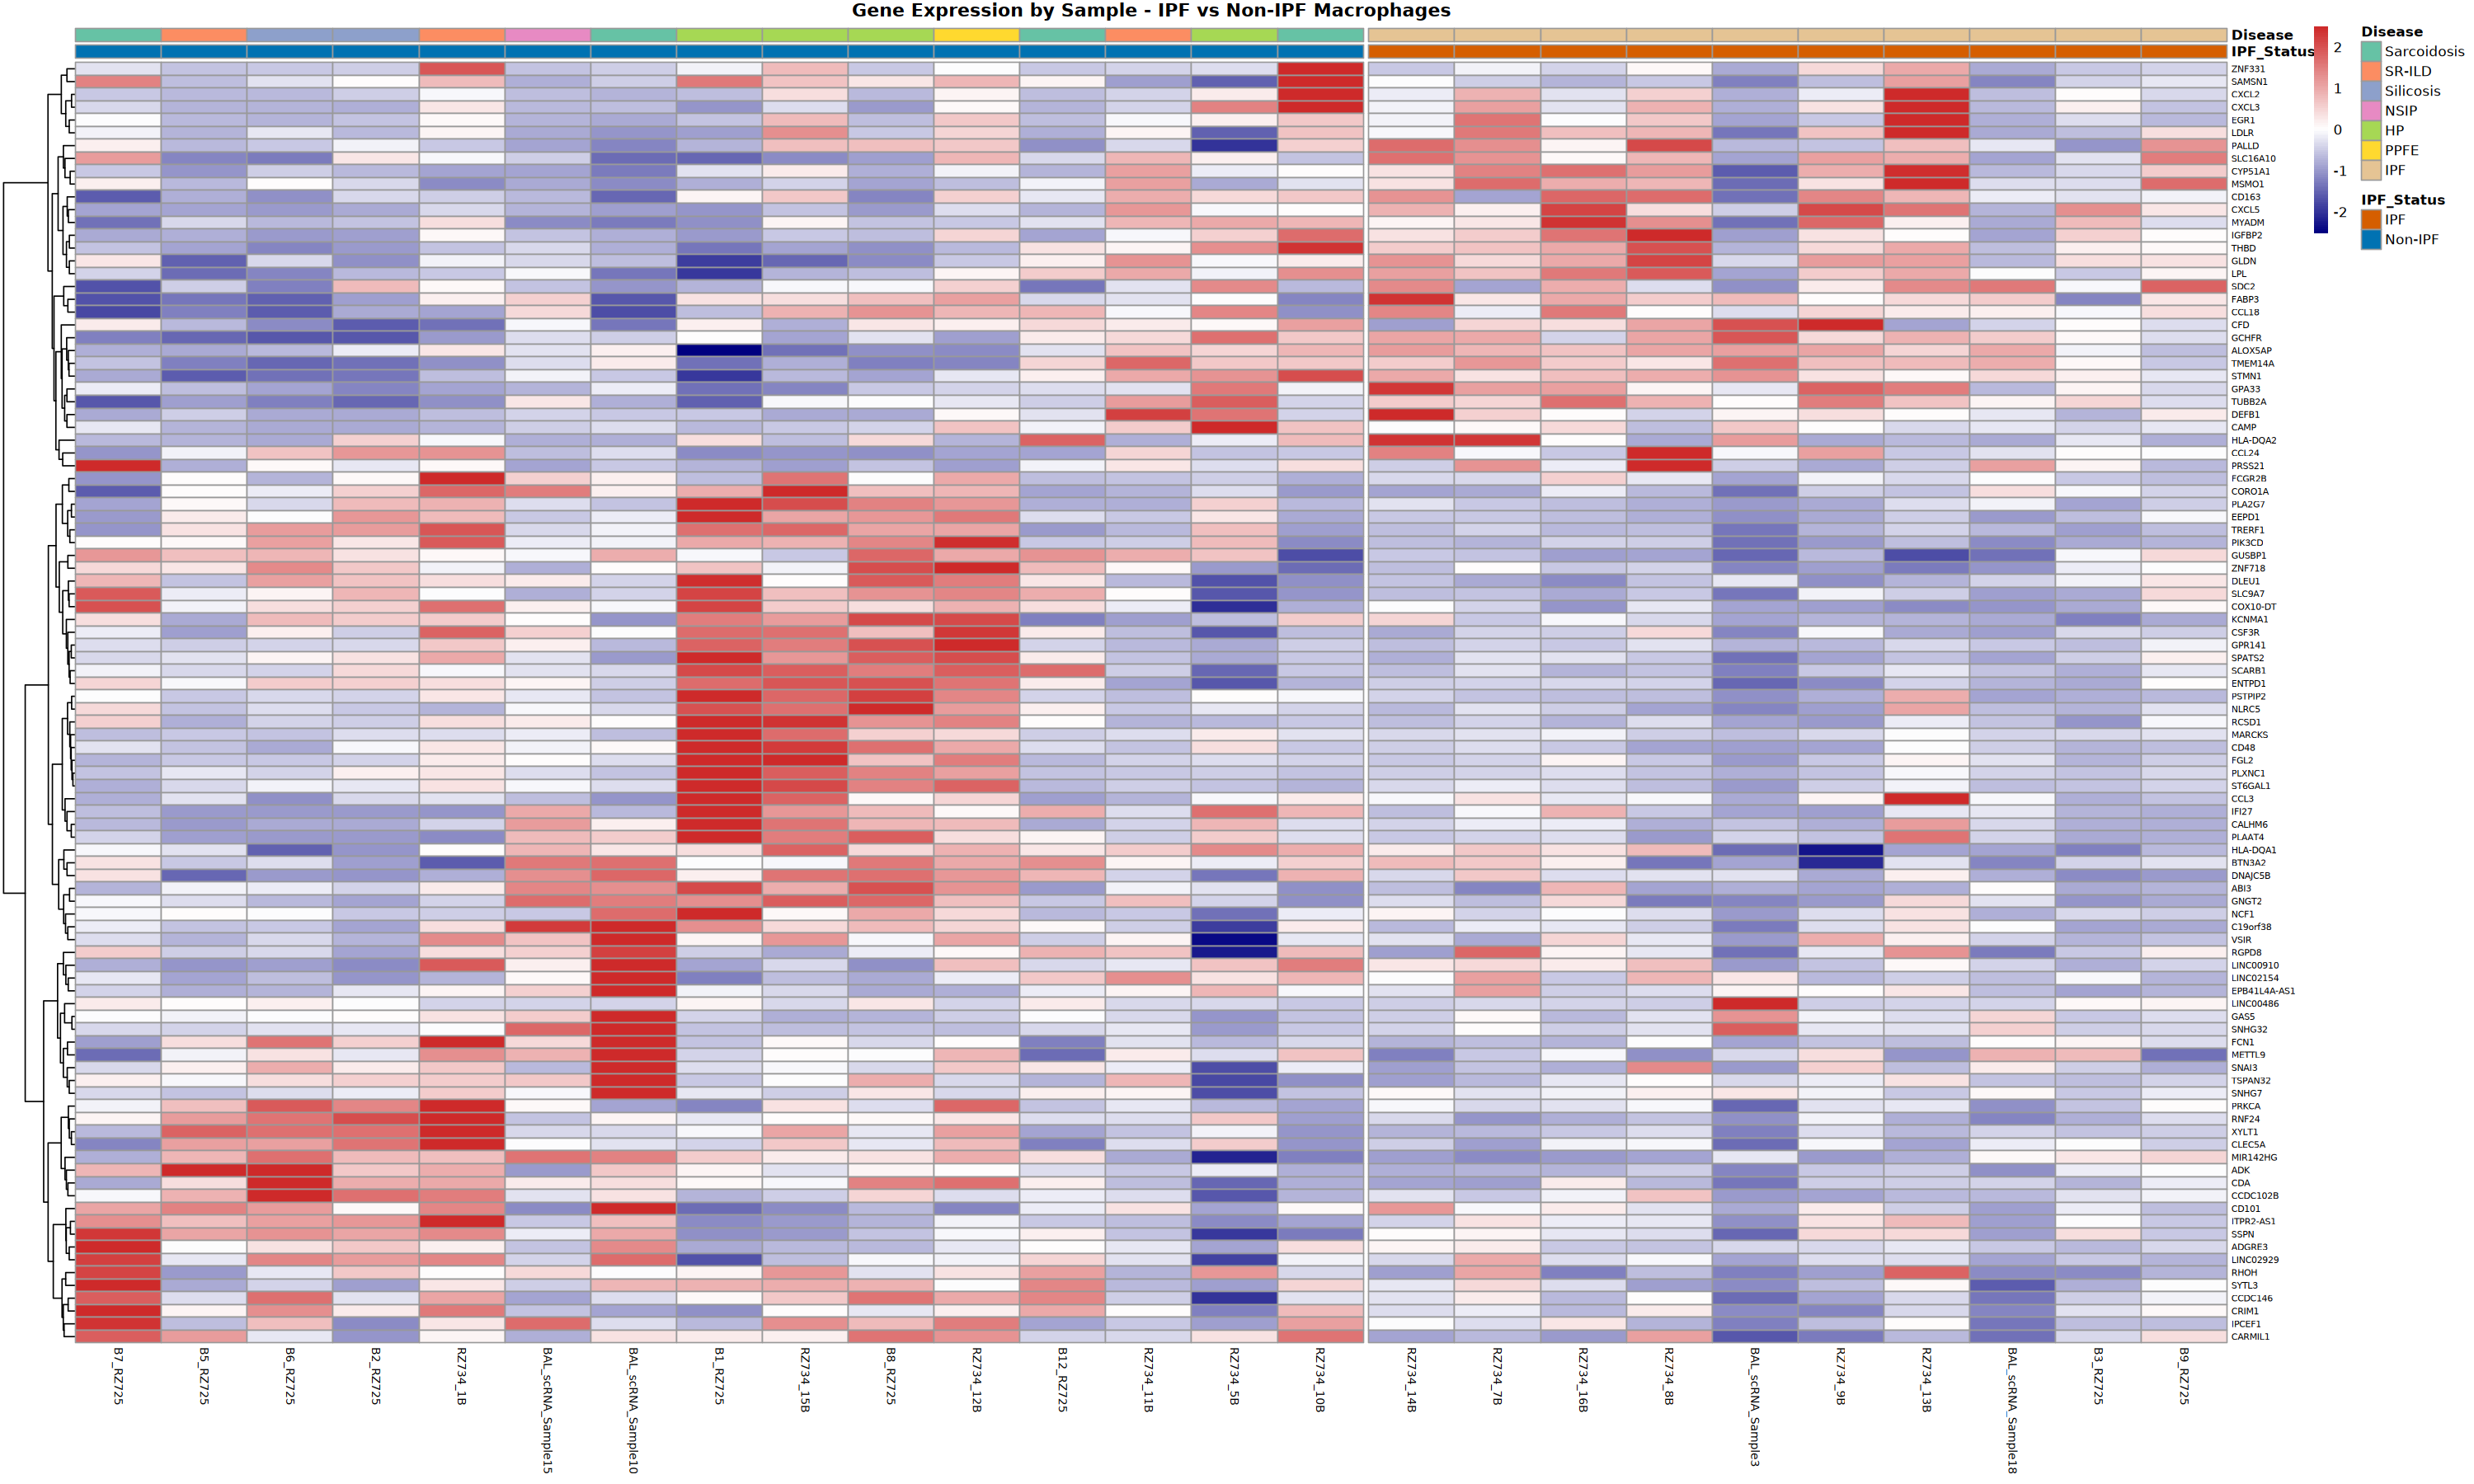

In [ ]:
# Set cell identities to IPF status
Idents(macs) <- "IPF"

# Run Seurat's differential expression analysis
de_results <- FindMarkers(
  macs,
  ident.1 = "IPF",
  ident.2 = "Non-IPF",
  min.pct = 0.1,
  logfc.threshold = 0,
  test.use = "wilcox",
  max.cells.per.ident = 5000,
  verbose = FALSE
)

# Process DE results or fallback to variable genes
if(is.data.frame(de_results) && nrow(de_results) > 0) {
  # Sort by absolute log fold change
  de_results$abs_avg_logFC <- abs(de_results$avg_log2FC)
  de_results <- de_results[order(de_results$abs_avg_logFC, decreasing = TRUE),]

  # Filter out genes starting with "ENSG"
  de_genes_filtered <- rownames(de_results)[!grepl("^ENSG", rownames(de_results))]

  # Get top 100 genes (after filtering out ENSG genes)
  variable_genes <- de_genes_filtered[1:min(100, length(de_genes_filtered))]
} else {
  # Fallback to variable genes
  all_var_genes <- VariableFeatures(macs)
  var_genes_filtered <- all_var_genes[!grepl("^ENSG", all_var_genes)]
  variable_genes <- var_genes_filtered[1:min(100, length(var_genes_filtered))]
}

# Fallback if no genes are found
if(length(variable_genes) == 0) {
  all_var_genes <- VariableFeatures(macs)
  var_genes_filtered <- all_var_genes[!grepl("^ENSG", all_var_genes)]
  variable_genes <- var_genes_filtered[1:min(100, length(var_genes_filtered))]
}

# Extract normalized expression data for these genes
expr_matrix <- GetAssayData(macs, slot = "data")[variable_genes, ]

# Convert to dense matrix if needed
if(inherits(expr_matrix, "dgCMatrix")) {
  expr_matrix <- as.matrix(expr_matrix)
}

# Get metadata
metadata <- macs@meta.data

# Create a mapping of samples to their IPF status
sample_info <- unique(metadata[, c("Sample", "IPF")])
rownames(sample_info) <- sample_info$Sample

# Get samples and their IPF status
samples <- unique(metadata$Sample)
nonipf_samples <- samples[sample_info[samples, "IPF"] == "Non-IPF"]

# Create a matrix to store the average expression for each sample
avg_expr <- matrix(0, nrow = length(variable_genes), ncol = length(samples))
rownames(avg_expr) <- variable_genes
colnames(avg_expr) <- samples

# Calculate average expression for each sample
for(sample_name in samples) {
  cell_indices <- which(metadata$Sample == sample_name)
  if(length(cell_indices) > 0) {
    avg_expr[, sample_name] <- rowMeans(expr_matrix[, cell_indices, drop = FALSE])
  }
}

# Get IPF status for each sample
sample_ipf <- setNames(sample_info$IPF, sample_info$Sample)

# Specified sample ordering
# List of non-IPF samples in the desired order
nonipf_ordered <- c("B7_RZ725", "B5_RZ725", "B6_RZ725", "B2_RZ725", "RZ734_1B",
                   "BAL_scRNA_Sample15", "BAL_scRNA_Sample10", "B1_RZ725",
                   "RZ734_15B", "B8_RZ725", "RZ734_12B", "B12_RZ725",
                   "RZ734_11B", "RZ734_5B", "RZ734_10B")

# List of IPF samples in the desired order
ipf_ordered <- c("RZ734_14B", "RZ734_7B", "RZ734_16B", "RZ734_8B", "BAL_scRNA_Sample3",
                "RZ734_9B", "RZ734_13B", "BAL_scRNA_Sample18", "B3_RZ725", "B9_RZ725")

# Create ordered sample list: Non-IPF first, then IPF
ordered_samples <- c(nonipf_ordered, ipf_ordered)

# Make sure we only include samples that exist in our data
ordered_samples <- ordered_samples[ordered_samples %in% colnames(avg_expr)]

# Reorder the expression matrix columns
avg_expr <- avg_expr[, ordered_samples]

# Remove any rows (genes) with NA, NaN or Inf values before scaling
has_bad_values <- apply(avg_expr, 1, function(x) any(is.na(x) | is.nan(x) | is.infinite(x)))
if(any(has_bad_values)) {
  avg_expr <- avg_expr[!has_bad_values, ]
}

# Scale each gene individually, handling zero variance properly
avg_expr_scaled <- t(scale(t(avg_expr), center = TRUE, scale = TRUE))

# For genes with zero standard deviation, set scaled values to 0
zero_sd_rows <- which(apply(avg_expr, 1, sd) == 0)
if(length(zero_sd_rows) > 0) {
  avg_expr_scaled[zero_sd_rows, ] <- 0
}

# Replace any NAs that might have been introduced during scaling
avg_expr_scaled[is.na(avg_expr_scaled)] <- 0

# Cap extreme values
avg_expr_scaled[avg_expr_scaled > 2.5] <- 2.5
avg_expr_scaled[avg_expr_scaled < -2.5] <- -2.5

# Create annotation for the heatmap columns
column_annotation <- data.frame(
  IPF_Status = sample_ipf[colnames(avg_expr)],
  row.names = colnames(avg_expr)
)

# Add disease_final annotation
if("disease_final" %in% colnames(metadata)) {
  disease_vector <- character(length(ordered_samples))
  names(disease_vector) <- ordered_samples

  for(sample_name in ordered_samples) {
    # Find cells for this sample
    sample_cells <- which(metadata$Sample == sample_name)
    if(length(sample_cells) > 0) {
      # Get the most common disease_final value
      disease_values <- as.character(metadata$disease_final[sample_cells])
      disease_table <- table(disease_values)
      disease_vector[sample_name] <- names(which.max(disease_table))
    }
  }

  # Add to annotation
  column_annotation$Disease <- disease_vector

  # Create disease colors
  disease_types <- unique(disease_vector[!is.na(disease_vector)])
  n_diseases <- length(disease_types)

  if(n_diseases > 0) {
    disease_colors <- setNames(
      colorRampPalette(brewer.pal(min(9, n_diseases), "Set2"))(n_diseases),
      disease_types
    )

    # Define colors for annotations
    ipf_colors <- c("IPF" = "#D55E00", "Non-IPF" = "#0072B2")
    ann_colors <- list(
      IPF_Status = ipf_colors,
      Disease = disease_colors
    )
  } else {
    column_annotation$Disease <- NULL
    ipf_colors <- c("IPF" = "#D55E00", "Non-IPF" = "#0072B2")
    ann_colors <- list(IPF_Status = ipf_colors)
  }
} else {
  ipf_colors <- c("IPF" = "#D55E00", "Non-IPF" = "#0072B2")
  ann_colors <- list(IPF_Status = ipf_colors)
}

# Find gap position between IPF and non-IPF
ipf_gap <- sum(ordered_samples %in% nonipf_ordered)

# Generate the heatmap
pheatmap(
  avg_expr_scaled,
  annotation_col = column_annotation,
  annotation_colors = ann_colors,
  show_colnames = TRUE,
  cluster_cols = FALSE,
  cluster_rows = TRUE,
  clustering_method = "ward.D2",
  fontsize_row = 6,
  fontsize_col = 8,
  main = "Gene Expression by Sample - IPF vs Non-IPF Macrophages",
  gaps_col = ipf_gap,
  color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
  breaks = seq(-2.5, 2.5, length.out = 100)
)

## Figure 2b: UMAP of monocyte-like macrophage subclusters

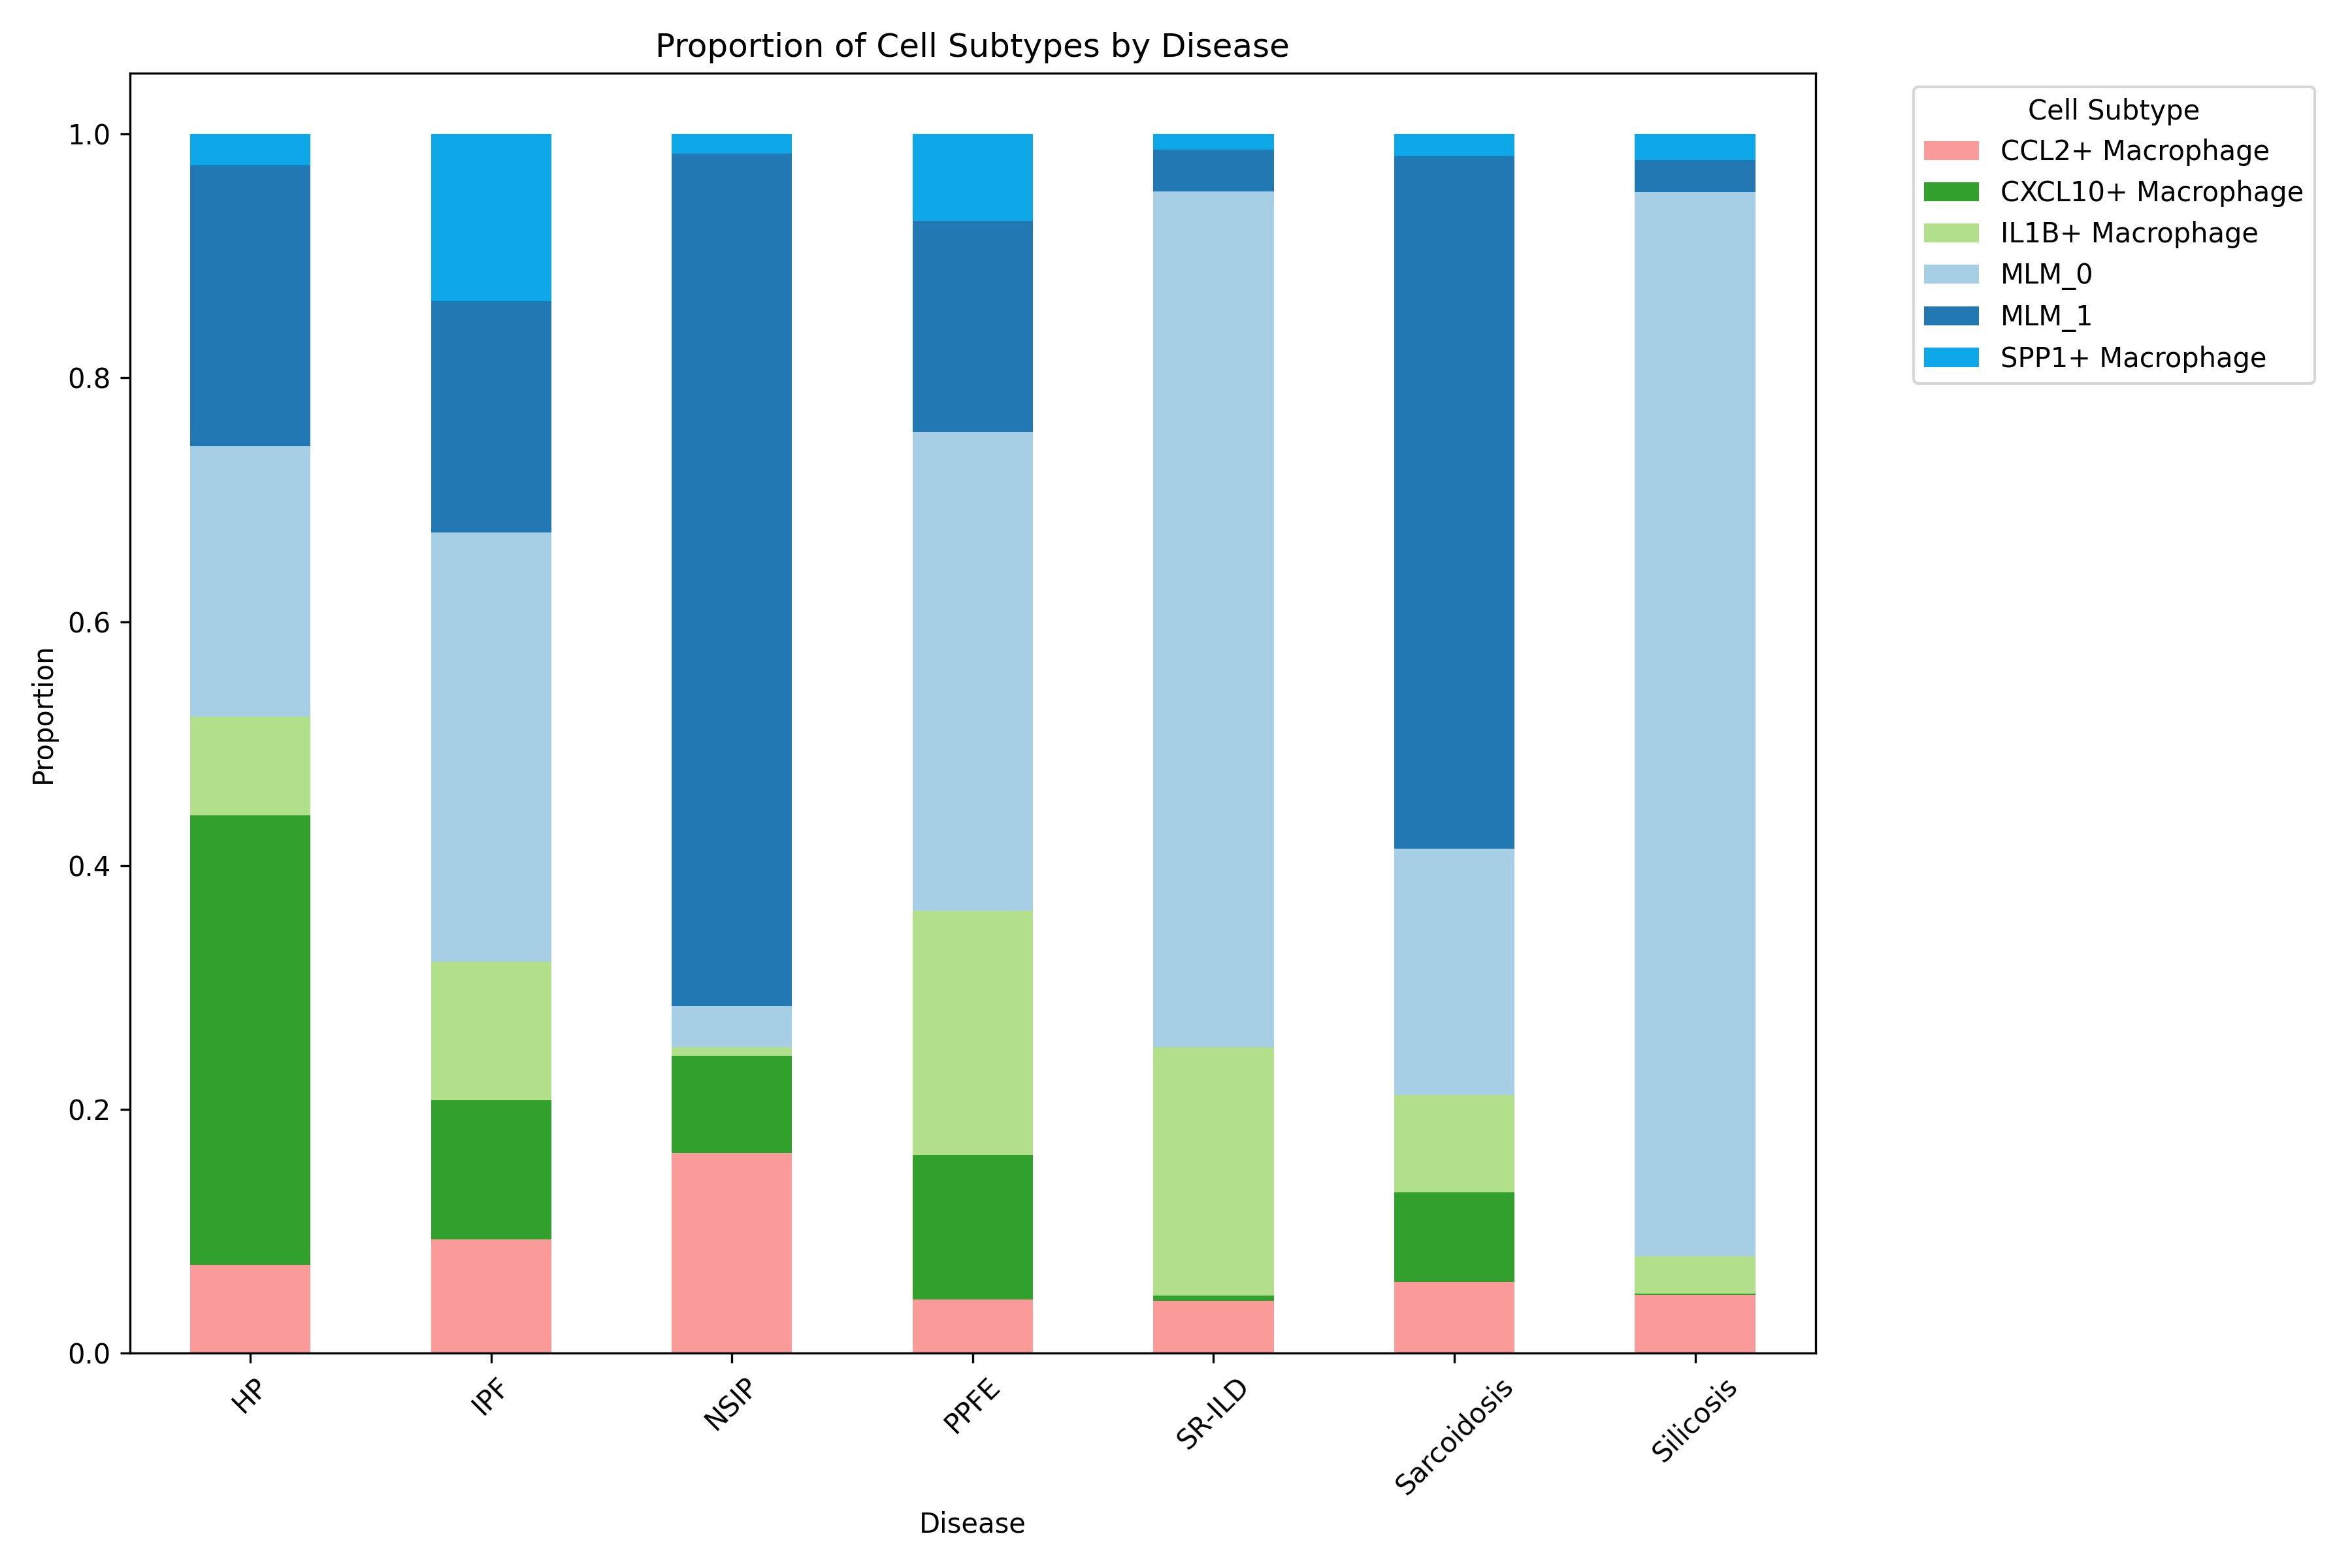

In [ ]:
import scanpy as sc
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams

# Initial setting for plot size
FIGSIZE = (15,10)
rcParams["figure.figsize"] = FIGSIZE

data = sc.read_h5ad('BAL_FINAL.h5ad')

celltypes = ['Alveolar macrophage', 'Monocyte-like macrophage', 'Proliferating alveolar macrophage', 'Interstitial-like macrophage']
data = data[data.obs['Cell_Subtype'].isin(celltypes)]

# Initialize the subtype column
data.obs['myeloid_subtype'] = data.obs['Cell_Sub_subtype']

# Assign Cell_Sub_subtype based on mdm_clusters values
data.obs['myeloid_subtype'] = data.obs['myeloid_subtype'].map({
    'MLM0': 'MLM_0',
    'MLM1': 'MLM_1',
    'IL1Bhi MLM': 'IL1B+ Macrophage',
    'CXCL10hi MLM': 'CXCL10+ Macrophage',
    'CCL2hi MLM': 'CCL2+ Macrophage',
    'SPP1hi MLM': 'SPP1+ Macrophage'
}).fillna(data.obs['myeloid_subtype'])

# Subset data to include only those listed in the map function
valid_subtypes = ['MLM_0', 'MLM_1', 'IL1B+ Macrophage', 'CXCL10+ Macrophage', 'CCL2+ Macrophage', 'SPP1+ Macrophage']
data = data[data.obs['myeloid_subtype'].isin(valid_subtypes)]

# Define custom colors for specific myeloid_subtype to match trajectory
custom_colors = {
    'MLM_0': '#a6cee4',
    'MLM_1': '#2178b3',
    'IL1B+ Macrophage': '#b2df8a',
    'CXCL10+ Macrophage': '#32a02d',
    'CCL2+ Macrophage': '#fb9b99',
    'SPP1+ Macrophage': '#0ea8e8'
}

# Assign the custom colors to the data.uns
data = data[data.obs['myeloid_subtype'].notna()]
data.obs['myeloid_subtype'] = data.obs['myeloid_subtype'].astype('category')
data.uns['myeloid_subtype_colors'] = [custom_colors.get(subtype, '#333333') for subtype in data.obs['myeloid_subtype'].cat.categories]

sc.pl.umap(data, color='myeloid_subtype', save=False, frameon=False, legend_loc='on data', title=None, size=100, legend_fontsize='30', legend_fontoutline=4)

plt.tight_layout()

## Figure 2c: Dotplot of top genes expressed by each macrophage subcluster

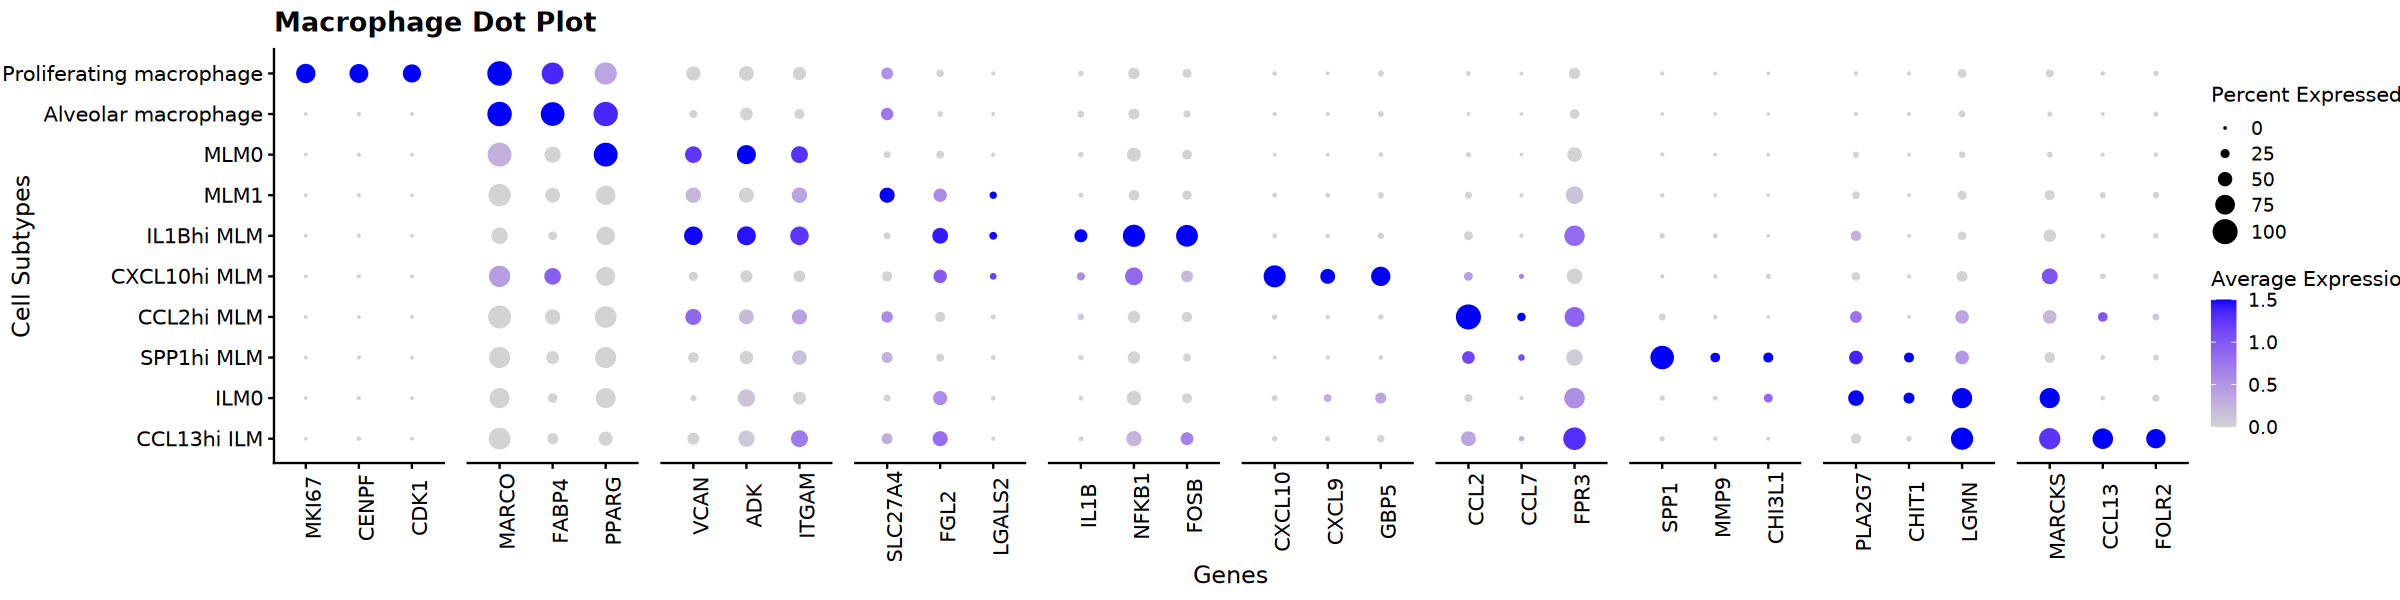

In [ ]:
genes <- list("Proliferating Macs" = c("MKI67", "CENPF", "CDK1"),
              "AM" = c("MARCO", "FABP4", "PPARG"),
              "MLM0" = c("VCAN", "ADK", "ITGAM"),
              "MLM1" = c("SLC27A4", "FGL2", "LGALS2"),
              "IL1Bhi MLM" = c("IL1B", "NFKB1", "FOSB"),
              "CXCL10hi MLM" = c("CXCL10", "CXCL9", "GBP5"),
              "CCL2hi MLM" = c("CCL2", "CCL7", "FPR3"),
              "SPP1hi MLM" = c("SPP1", "MMP9", "CHI3L1"),
              "ILM0" = c("PLA2G7", "CHIT1", "LGMN"),
              "CCL13hi ILM" = c("MARCKS", "CCL13", "FOLR2"))

macs <- SetIdent(macs, value = "Cell_Sub_subtype")
new_level_order <- c("CCL13hi ILM", "ILM0", "SPP1hi MLM", "CCL2hi MLM", "CXCL10hi MLM", "IL1Bhi MLM", "MLM1", "MLM0", "Alveolar macrophage", "Proliferating macrophage")
                                   levels = new_level_order)

a <- DotPlot(macs,
             features = genes,
             cols = c("lightgrey", "blue"),
             col.min = 0, col.max = 1.5, scale.min = 0, scale.max = 100)
options(repr.plot.width = 20, repr.plot.height = 5)
a + labs(title = "Macrophage Dot Plot", x = "Genes", y = "Cell Subtypes") + theme(axis.text.x = element_text(angle = 90), legend.text = element_text(size = 11), legend.title = element_text(size = 12)) + theme(strip.text = element_blank())